## Part 1: CNN from Scratch (Full Implementation)


### Step 1: Import Libraries and Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load MNIST dataset from TensorFlow
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()  ## shape(60000,28,28,1) (60000,10)

# Normalize and reshape the data # (0 -> 255, 0 -> 1)
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode labels (0 ->9 )
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28, 1)

### Step 2: Define Helper Functions


In [ ]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def relu_derivative(x):       ## for backward propagation
    return (x > 0).astype(float)

### Step 3: Build the CNN from Scratch


In [ ]:
import numpy as np

class SimpleCNN:
    def __init__(self):
        # Initialize weights and biases
        self.conv1_filters = np.random.randn(8, 3, 3, 1) * 0.1  # 8 filters, 3x3 kernel
        self.conv1_bias = np.zeros((8, 1))  # Bias for 8 filters
        self.conv2_filters = np.random.randn(16, 3, 3, 8) * 0.1  # 16 filters, 3x3 kernel
        self.conv2_bias = np.zeros((16, 1))  # Bias for 16 filters

        # Fully connected layer dimensions
        self.fc1_weights = np.random.randn(16 * 5 * 5, 128) * 0.1  # Adjusted to match flattened output
        self.fc1_bias = np.zeros((128,))
        self.fc2_weights = np.random.randn(128, 10) * 0.1  # Output layer
        self.fc2_bias = np.zeros((10,))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def convolve(self, X, filters, bias):
        batch_size, height, width, channels = X.shape
        num_filters, kernel_height, kernel_width, _ = filters.shape
        output_height = height - kernel_height + 1
        output_width = width - kernel_width + 1
        output = np.zeros((batch_size, output_height, output_width, num_filters))
        for i in range(output_height):
            for j in range(output_width):
                region = X[:, i:i+kernel_height, j:j+kernel_width, :]
                output[:, i, j, :] = np.tensordot(region, filters, axes=([1, 2, 3], [1, 2, 3])) + bias.T
        return self.relu(output)

    def max_pool(self, X, pool_size=2):
        batch_size, height, width, channels = X.shape
        output_height = height // pool_size
        output_width = width // pool_size
        output = np.zeros((batch_size, output_height, output_width, channels))
        for i in range(0, height - pool_size + 1, pool_size):
            for j in range(0, width - pool_size + 1, pool_size):
                region = X[:, i:i+pool_size, j:j+pool_size, :]
                output[:, i//pool_size, j//pool_size, :] = np.max(region, axis=(1, 2))
        return output

    def forward(self, X):
        self.conv1_out = self.convolve(X, self.conv1_filters, self.conv1_bias)
      #  print(f"Conv1 output shape: {self.conv1_out.shape}")

        self.pool1_out = self.max_pool(self.conv1_out)
     #   print(f"Pool1 output shape: {self.pool1_out.shape}")

        self.conv2_out = self.convolve(self.pool1_out, self.conv2_filters, self.conv2_bias)
       # print(f"Conv2 output shape: {self.conv2_out.shape}")

        self.pool2_out = self.max_pool(self.conv2_out)
       # print(f"Pool2 output shape: {self.pool2_out.shape}")

        self.flatten_out = self.pool2_out.reshape(X.shape[0], -1)
        #print(f"Flatten output shape: {self.flatten_out.shape}")

        self.fc1_out = self.relu(np.dot(self.flatten_out, self.fc1_weights) + self.fc1_bias)
        self.fc2_out = np.dot(self.fc1_out, self.fc2_weights) + self.fc2_bias
        return self.softmax(self.fc2_out)

    def backward(self, X, y, learning_rate=0.001):
        # Forward pass
        self.forward(X)

        # Backward pass for the output layer
        d_fc2 = (self.fc2_out - y) / y.shape[0]
        d_fc2_weights = np.dot(self.fc1_out.T, d_fc2)
        d_fc2_bias = np.sum(d_fc2, axis=0)

        # Backward pass for the first fully connected layer
        d_fc1 = np.dot(d_fc2, self.fc2_weights.T) * (self.fc1_out > 0)
        d_fc1_weights = np.dot(self.flatten_out.T, d_fc1)
        d_fc1_bias = np.sum(d_fc1, axis=0)

        # Update weights and biases
        self.fc2_weights -= learning_rate * d_fc2_weights
        self.fc2_bias -= learning_rate * d_fc2_bias
        self.fc1_weights -= learning_rate * d_fc1_weights
        self.fc1_bias -= learning_rate * d_fc1_bias


# Instantiate and test the CNN
cnn = SimpleCNN()
predictions = cnn.forward(X_train[:32])
print("Initial predictions shape:", predictions.shape)

Initial predictions shape: (32, 10)


### Step 4: Train the CNN


In [ ]:
num_epochs = 10
batch_size = 32
for epoch in range(num_epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        cnn.backward(X_batch, y_batch, learning_rate=0.001)
    train_preds = cnn.forward(X_train[:1000])
    train_acc = np.mean(np.argmax(train_preds, axis=1) == np.argmax(y_train[:1000], axis=1))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_acc:.2f}")

Epoch 1/10, Training Accuracy: 0.21
Epoch 2/10, Training Accuracy: 0.38
Epoch 3/10, Training Accuracy: 0.48
Epoch 4/10, Training Accuracy: 0.54


KeyboardInterrupt: 

### Step 5: Visualize Predictions

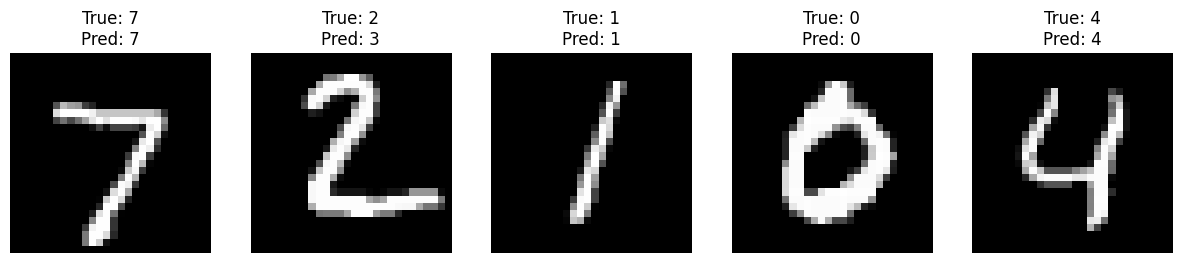

In [ ]:
sample_images = X_test[:5]
sample_labels = y_test[:5]
sample_preds = cnn.forward(sample_images)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {np.argmax(sample_labels[i])}\nPred: {np.argmax(sample_preds[i])}")
    ax.axis('off')
plt.show()

## Part 2: TensorFlow Implementation


### Step 1: Define and Train TensorFlow Model


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a TensorFlow CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8971 - loss: 0.3535 - val_accuracy: 0.9805 - val_loss: 0.0601
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9874 - val_loss: 0.0364
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9918 - loss: 0.0297 - val_accuracy: 0.9894 - val_loss: 0.0285
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9936 - loss: 0.0213 - val_accuracy: 0.9891 - val_loss: 0.0328
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.9905 - val_loss: 0.0298


### Step 2: Evaluate TensorFlow Model


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9881 - loss: 0.0374
Test Accuracy: 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


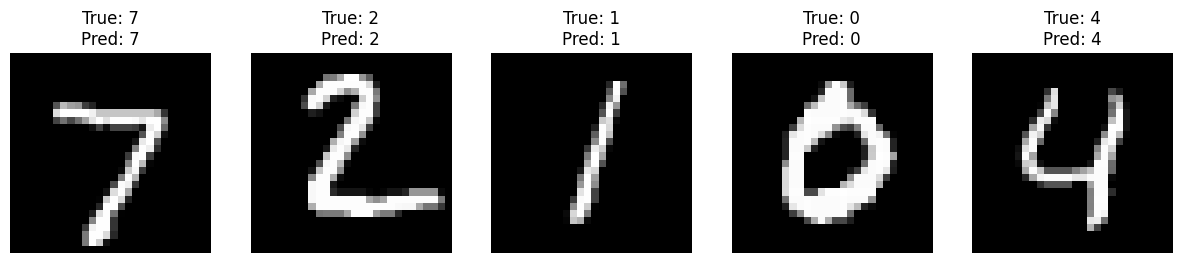

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot predictions
sample_preds = model.predict(X_test[:5])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {np.argmax(y_test[i])}\nPred: {np.argmax(sample_preds[i])}")
    ax.axis('off')
plt.show()

## Part 3: Pretrained Models


### Step 1: Load and Evaluate Pretrained VGG16 Model


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import numpy as np

# Load pretrained VGG16 model
vgg16 = VGG16(weights='imagenet')

# Preprocess an image
image_path = tf.keras.utils.get_file('dog.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg')
img = load_img(image_path, target_size=(224, 224))
img_array = preprocess_input(img_to_array(img))
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = vgg16.predict(img_array)
labels = decode_predictions(predictions, top=10)

for (i, (imagenetID, label, prob)) in enumerate(labels[0]):
    print(f"{i + 1}: {label} ({prob * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1: golden_retriever (65.81%)
2: cocker_spaniel (9.55%)
3: kuvasz (9.51%)
4: Great_Pyrenees (5.34%)
5: standard_poodle (4.86%)
6: Tibetan_mastiff (1.43%)
7: Sussex_spaniel (0.95%)
8: Newfoundland (0.72%)
9: clumber (0.38%)
10: Tibetan_terrier (0.29%)


In [ ]:
labels

[[('n02099601', 'golden_retriever', 0.65813494),
  ('n02102318', 'cocker_spaniel', 0.095494196),
  ('n02104029', 'kuvasz', 0.0950829),
  ('n02111500', 'Great_Pyrenees', 0.053361345),
  ('n02113799', 'standard_poodle', 0.04863863),
  ('n02108551', 'Tibetan_mastiff', 0.014252542),
  ('n02102480', 'Sussex_spaniel', 0.009525103),
  ('n02111277', 'Newfoundland', 0.007249468),
  ('n02101556', 'clumber', 0.003813758),
  ('n02097474', 'Tibetan_terrier', 0.0029327478)]]

In [ ]:
predictions

array([[9.94376359e-10, 1.09725083e-10, 4.60833427e-10, 1.91414870e-10,
        1.06831288e-09, 6.68992683e-09, 3.72707154e-09, 5.59427171e-09,
        1.25858705e-07, 1.90402316e-09, 2.27975097e-10, 5.02688002e-10,
        1.68393288e-09, 2.32844810e-09, 2.40681897e-09, 5.46976686e-10,
        4.50230353e-10, 1.61385671e-09, 1.99250505e-09, 7.79720200e-09,
        5.70258507e-09, 1.31446021e-10, 4.12971213e-09, 8.92260310e-09,
        3.86806249e-08, 2.86983104e-09, 3.82259335e-10, 1.67481362e-09,
        2.02089301e-09, 1.05105036e-09, 3.29955996e-09, 1.63037903e-08,
        1.32883535e-08, 7.47003082e-09, 8.67645156e-09, 1.65860392e-09,
        9.95745264e-09, 1.17065424e-09, 4.55968679e-10, 3.34819772e-09,
        1.37594669e-09, 4.50711496e-10, 2.34098269e-10, 2.19290963e-09,
        2.15389276e-10, 3.37579720e-09, 5.76789105e-09, 2.52671128e-09,
        1.04141460e-08, 4.67958605e-09, 1.03922995e-08, 1.30922140e-09,
        1.60440672e-09, 3.54172580e-10, 1.72814263e-09, 8.017032

### Step 2: Visualize the Model Architecture


In [ ]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
custom_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

              ## bysheel mn awl flatten 3shan yfdy memory l2n dh el goz2 el ms2ol 3n predictions w msh 3ayzo
              ## ama ely abl flatten ms2ool 3n t7deed features


In [ ]:
print(custom_model.summary())

for layer in custom_model.layers:
    layer.trainable = False

print(custom_model.summary())

### == transfer learning = bgeeb model mtmrn abl kedaw a3mlo customize l 7aga lya
model = Sequential([custom_model,
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(2, activation='sigmoid')
                    ])
print(model.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 120)                 │       3,010,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             242 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,725,610 (67.62 MB)

 Trainable params: 3,010,922 (11.49 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Step 3: Load VGG16 Architecture without Weights to use its Architecture only

In [ ]:
vgg16_no_weights = VGG16(include_top = False, weights=None,input_shape=(224,224,3))  ## use its Architecture only
vgg16_no_weights.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential([vgg16_no_weights,
                    Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(2, activation='sigmoid')
                    ])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 5, 32)            │         147,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 120)                 │          15,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             242 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,877,898 (56.75 MB)

 Trainable params: 14,877,898 (56.75 MB)

 Non-trainable params: 0 (0.00 B)